In [0]:
import pandas as pd
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import operator
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# **Get Stock Data**

In [0]:
def get_single_stock_data(start_date, end_date, symbol):
    data = web.DataReader(symbol, "yahoo", start_date, end_date)
    return data

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2019, 1, 1)
symbol = "AAPL"

data = lambda x : get_single_stock_data(start_date,end_date,x)
datad = lambda x,start_date,end_date : get_single_stock_data(start_date,end_date,x)
d1_rtrn = lambda x : x['Adj Close'].pct_change(1).dropna()
std = lambda x : np.std(x)

df = data(symbol)

# Stock Adjust Close price instagram

Date
2010-01-04         NaN
2010-01-05    0.001727
2010-01-06   -0.016034
2010-01-07   -0.001850
2010-01-08    0.006626
                ...   
2018-12-24   -0.026215
2018-12-26    0.068052
2018-12-27   -0.006511
2018-12-28    0.000512
2018-12-31    0.009619
Name: Daily Log Rate of Return, Length: 2264, dtype: float64
0.016194558145925214


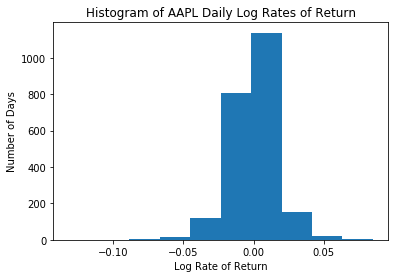

In [22]:
df['Daily Log Rate of Return'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))

print(df['Daily Log Rate of Return'])

stdev = np.std(df['Daily Log Rate of Return'])
print(stdev)

plt.hist(df['Daily Log Rate of Return'].dropna())
plt.title('Histogram of AAPL Daily Log Rates of Return')
plt.xlabel('Log Rate of Return')
plt.ylabel('Number of Days')
plt.show()

# Candle Stick Chart

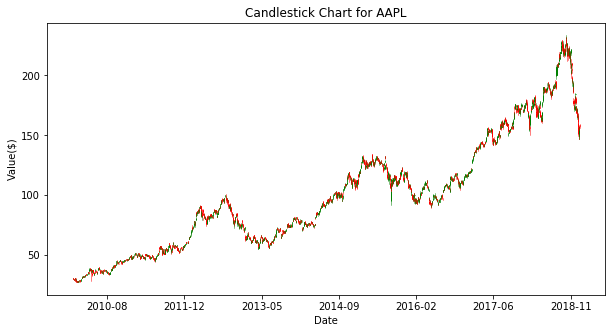

In [34]:
df.index = pd.to_datetime(df.index)
df1 = pd.DataFrame(df.index)

df1["Date"] = df1["Date"].apply(mdates.date2num)

df1.index = df.index

candle_data = pd.DataFrame({
    'Date' : df1['Date'],
    'Open' : df['Open'],
    'High' : df['High'],
    'Low' : df['Low'],
    'Close' : df['Close']
    })

f1, ax = plt.subplots(figsize = (10,5))
candlestick_ohlc(ax,candle_data.values, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Candlestick Chart for AAPL')
plt.xlabel('Date')
plt.ylabel('Value($)')
plt.show()


# Efficient Frontier

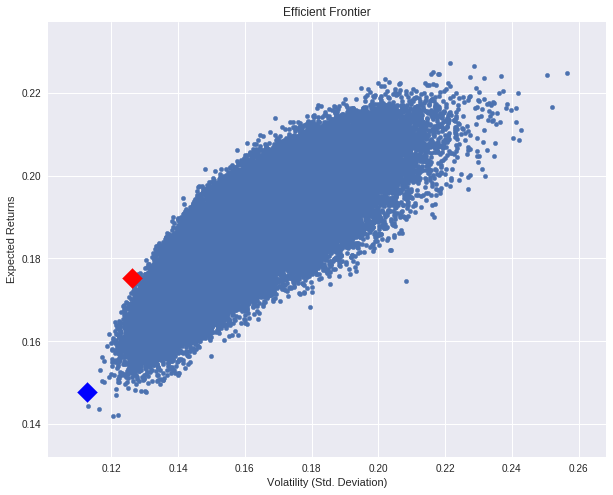

        Returns  Volatility  Sharpe Ratio  SBUX weight  LUV weight  MMC weight  PAG weight  REI weight  SHV weight  SWK weight  PEP weight  NEE weight  V weight
80865  0.175224    0.126088        1.3897     0.142391    0.049233    0.096615     0.04412    0.039302    0.127072    0.039782    0.122749     0.16814  0.170597
       Returns  Volatility  Sharpe Ratio  SBUX weight  LUV weight  MMC weight  PAG weight  REI weight  SHV weight  SWK weight  PEP weight  NEE weight  V weight
2417  0.147654     0.11254      1.312012     0.121303    0.056685    0.051626    0.053544    0.050061    0.218254    0.051276    0.198014    0.125981  0.073255


In [59]:
port = ['SBUX', 'LUV', 'MMC', 'PAG', 'REI', 'SHV', 'SWK', 'PEP', 'NEE', 'V']

def prtf_rtn(prtf_tkrs):
    x = d1_rtrn(data(prtf_tkrs[0]))
    df = pd.DataFrame(x)
    for i in range(1, len(prtf_tkrs)):
        y = d1_rtrn(data(prtf_tkrs[i]))
        df1 = pd.DataFrame(data = y)
        df = pd.concat([df, df1['Adj Close']], axis=1)
    return df

x = 0
y = 0
def prtf_std(prtf_tkrs):
    x = (d1_rtrn(data(prtf_tkrs[0])))
    df = pd.DataFrame(data=x)
    for i in range(1, len(prtf_tkrs)):
        y = (d1_rtrn(data(prtf_tkrs[i])))
        df1 = pd.DataFrame(data = y)
        df = pd.concat([df, df1['Adj Close']], axis=1) #.dropna() to get rid of all rows with any nan values
    return df

prtf_rtrn = []
prtf_vol = []
stock_wgt = []
shrp_rto = []

num_assets = len(port)
num_prtf = 100000

df1 = prtf_std(port)
df1.columns = port
df =df1

returns_daily = df
returns_daily = returns_daily.dropna()
returns_annual = returns_daily.mean()*250

cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250


for single_portfolio in range(num_prtf):
    weights = np.random.uniform(low = 0.01, high = 0.05, size = (num_assets,))  #np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    prtf_rtrn.append(returns)
    shrp_rto.append(sharpe)
    prtf_vol.append(volatility)
    stock_wgt.append(weights)

portfolio = {'Returns': prtf_rtrn,
             'Volatility': prtf_vol,
             'Sharpe Ratio': shrp_rto}

for counter,symbol in enumerate(port):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_wgt]

df = pd.DataFrame(portfolio)

column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' weight' for stock in port]

df = df[column_order]

# find min Volatility & max sharpe values in the dataframe (df)
min_vol = df['Volatility'].min()
max_shrp = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
shrp_prtf = df.loc[df['Sharpe Ratio'] == max_shrp]
min_var_prt = df.loc[df['Volatility'] == min_vol]

plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.scatter(x=shrp_prtf['Volatility'], y=shrp_prtf['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_var_prt['Volatility'], y=min_var_prt['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

print(shrp_prtf.to_string())
print(min_var_prt.to_string())